Remove spurious small islands of noise in an image

In [1]:
from PIL import Image
import cv2
import numpy as np
from skimage.morphology import area_opening
import sys
import os
from colorthief import ColorThief
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from glob import glob
import pandas as pd
import colorsys
import math
from collections import Counter

In [254]:
# Apply Area opening in order to denoise the picture
def clean_noise(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    img[:,:,3][area_opening(img[:,:,3], 12) == 0] = 0
    cv2.imwrite(image_path, img)

In [ ]:
# Load the image
img = cv2.imread('test_sprite.png', cv2.IMREAD_UNCHANGED)
img[:,:,3][area_opening(img[:,:,3], 12) == 0] = 0
cv2.imwrite('output.png', img)
# minimum size of image to identify and crop
minimumSize = 10

# Get colors on 4 corners
cornerCoord = [[0, 0], [0, -1], [-1, 0], [-1, -1]]
cornerColors = [img[c, r] for c, r in cornerCoord]
# select most frequent color in cornerColors
color, count = np.unique(cornerColors, return_counts=True, axis=0)
mostCommonColor = color[count == max(count)]

# it is pressumed that mostCommonColor is the background color

# mask is true  where img!=mostCommonColor
mask = np.all(img != mostCommonColor, axis=2).astype(np.uint8)

# find contours of masked image, and discard nested contours
contours, hierarchy = cv2.findContours(
    mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# discard contours of isolated pixels with size <10
contours = tuple(c for c in contours if c.size > minimumSize)

print(len(contours))

In [ ]:
# load image with alpha channel
img = cv2.imread('meganium.png', cv2.IMREAD_UNCHANGED)

# remove remaining unwanted pixel noise
img[:,:,3][area_opening(img[:,:,3], 12) == 0] = 0

# extract alpha channel
alpha = img[:, :, 3]

# threshold alpha channel
alpha = cv2.threshold(alpha, 0, 255, cv2.THRESH_BINARY)[1]

# save output
cv2.imwrite('alpha.png', alpha)

# load binary masked image
image = cv2.imread("alpha.png", cv2.IMREAD_GRAYSCALE)

# separate into rows and columns
M, N = image.shape

# count every blob
n_blobs = 0
for i in range(M):
    for j in range(N):
        if image[i, j] == 255:
            n_blobs += 1
            cv2.floodFill(image, None, (j, i), n_blobs)

# white background
cv2.floodFill(image, None, (0, 0), 255)

# count the blobs with holes
n_holes = 0
for i in range(M):
    for j in range(N):
        if image[i, j] == 0:
            if 0 < image[i, j-1] < 255:
                n_holes += 1
            cv2.floodFill(image, None, (j, i), 255)

print('TOTAL BLOBS:', n_blobs)
print('TOTAL HOLES:', n_holes)
print('TOTAL IMPERFECTIONS:', n_blobs + n_holes)

In [42]:
def addTransparency(image_path):
    img = Image.open(SPRITES_FRONT_ROOT + image_path)
    img = img.convert("RGBA")
 
    datas = img.getdata()
 
    newData = []
 
    for item in datas:
        if item[0] > 254 and item[1] > 254 and item[2] > 254:
            newData.append((255, 255, 255, 0))
        else:
            newData.append(item)
 
    img.putdata(newData)
    img.save(SPRITES_FRONT_ROOT_TRANSPARENT + image_path, "PNG")
    return img

In [260]:
def calculate_blobs_and_holes_for_sprite(image_path):
    # load image with alpha channel
    img = cv2.imread(FOLDER_FOR_BLOBS_AND_HOLES + image_path, cv2.IMREAD_UNCHANGED)

    # remove remaining unwanted pixel noise
    img[:,:,3][area_opening(img[:,:,3], 12) == 0] = 0

    # extract alpha channel
    alpha = img[:, :, 3]

    # threshold alpha channel
    alpha = cv2.threshold(alpha, 0, 255, cv2.THRESH_BINARY)[1]

    # save output
    cv2.imwrite('alpha.png', alpha)

    # load binary masked image
    image = cv2.imread("alpha.png", cv2.IMREAD_GRAYSCALE)

    # separate into rows and columns
    M, N = image.shape

    # count every blob
    n_blobs = 0
    for i in range(M):
        for j in range(N):
            if image[i, j] == 255:
                n_blobs += 1
                cv2.floodFill(image, None, (j, i), n_blobs)

    # white background
    cv2.floodFill(image, None, (0, 0), 255)

    # count the blobs with holes
    n_holes = 0
    for i in range(M):
        for j in range(N):
            if image[i, j] == 0:
                if 0 < image[i, j-1] < 255:
                    n_holes += 1
                cv2.floodFill(image, None, (j, i), 255)

    # print('TOTAL BLOBS:', n_blobs)
    # print('TOTAL HOLES:', n_holes)
    # print('TOTAL IMPERFECTIONS:', n_blobs + n_holes)
    return [n_blobs, n_holes, n_blobs + n_holes]

In [2]:
# Iterate through all front facing sprites and make them transparent: 
SPRITES_FRONT_ROOT =  "D:\IDG_Malta_Master_Thesis\pokemon_assets_generation\_Sprite_Sheets\PokeTypeGAN-main\sprites_front_only/"
SPRITES_FRONT_ROOT_TRANSPARENT =  "D:\IDG_Malta_Master_Thesis\pokemon_assets_generation\_Sprite_Sheets\PokeTypeGAN-main\\sprite_fronts_only_transparent_2/"
folder_dir = SPRITES_FRONT_ROOT
# for image in os.listdir(folder_dir):
#     addTransparency(image)

In [ ]:
# now that we have transparent original sprites we can do the statistics on them
# average number of islands/blobs 
# average number of holes 
# sprite with most blobs 
# sprite with most holes
FOLDER_FOR_BLOBS_AND_HOLES = "D:\IDG_Malta_Master_Thesis\pokemon_assets_generation\_Sprite_Sheets\PokeTypeGAN-main\\all_transparent\generated_shapes\\wings/"
blobs_list = []
holes_list = []
imperfections_list = []
most_blobs = 0
most_blobs_sprite = "none"
most_holes = 0
most_holes_sprite = "none"
most_imperfections = 0
most_imperfections_sprite = "none"
avg_blobs = 0
avg_holes = 0
avg_imperfections = 0
folder_dir_transparent = FOLDER_FOR_BLOBS_AND_HOLES
for image in os.listdir(folder_dir_transparent):
    # print(image)
    results = calculate_blobs_and_holes_for_sprite(image)
    # print(results)
    blobs_list.append(results[0])
    holes_list.append(results[1])
    imperfections_list.append(results[2])
    if results[0] > most_blobs:
        most_blobs = results[0]
        most_blobs_sprite = image
    if results[1] > most_holes:
        most_holes = results[1]
        most_holes_sprite = image
    if results[2] > most_imperfections:
        most_imperfections = results[2]
        most_imperfections_sprite = image
import numpy as np

avg_blobs = np.average(blobs_list)
avg_holes = np.average(holes_list)
avg_imperfections = np.average(imperfections_list)

print("Average blobs in original sprites: " + str(avg_blobs))
print("Average holes in original sprites: " + str(avg_holes))
print("Average imperfections in original sprites: " + str(avg_imperfections))

print("Pokemon with most blobs: " + str(most_blobs_sprite) + " with " + str(most_blobs) + " blobs.")
print("Pokemon with most holes: " + str(most_holes_sprite) + " with " + str(most_holes) + " holes.")
print("Pokemon with most imperfections: " + str(most_imperfections_sprite) + " with " + str(most_imperfections) + " imperfections.")

Get pokemon pallete

In [5]:
def get_color_palette(image_path):
    # create ColorThief object with image path
    color_thief = ColorThief(image_path)

    # get the dominant color
    dominant_color = color_thief.get_color(quality=1)

    # create a figure and axis
    fig, ax = plt.subplots(figsize=(1, 1))

    # create a horizontal bar chart for the dominant color
    ax.bar(0, 1, color=np.array(dominant_color)/255)

    # remove ticks and labels
    ax.set_xticks([0])
    ax.set_yticks([])
    ax.set_xticklabels(["Dominant"])
    ax.set_yticklabels([])

    # set axis limits
    ax.set_ylim([0, 1])

    # display the plot
    plt.savefig("colors.png")
    plt.show()
    return(dominant_color)

In [ ]:
dominant_color = get_color_palette("D:\IDG_Malta_Master_Thesis\pokemon_assets_generation\_Sprite_Sheets\PokeTypeGAN-main\sprites\individual\\types\\bug\Bug_fakemon_0.png")
print(dominant_color)

In [ ]:
# Compute most dominant color for all original sprites
type_folders = glob("_saved_original_sprites/*")
print(type_folders)
for type in type_folders:
    all_sprites = glob(type + "/*png")
    dominant_colors = []
    for sprite in all_sprites:
        dominant_color = get_color_palette(sprite)
        # print(dominant_color)
        dominant_colors.append(dominant_color)
    df = pd.DataFrame(dominant_colors).T
    df.to_excel(excel_writer=type.partition("\\")[2] + ".xlsx")


In [ ]:
# Compute most dominant color for all generated sprites
type_folders = glob("individual/types/*")
# print(type_folders)
for type in type_folders:
    all_sprites = glob(type + "/*png")
    # print(type)
    dominant_colors = []
    for sprite in all_sprites:
        dominant_color = get_color_palette(sprite)
        print(dominant_color)
        dominant_colors.append(dominant_color)
    df = pd.DataFrame(dominant_colors).T
    df.to_excel(excel_writer=type.partition("\\")[2] + ".xlsx")

In [ ]:
list_of_colors_RGB = [
    [255,0,0],      # RED       #FF0000
    [0,0,255],      # BLUE      #0000FF
    [255,255,0],    # YELLOW    #FFFF00
    [0,255,0],      # GREEN     #00FF00
    [0,0,0],        # BLACK     #000000
    [150,75,0],     # BROWN     #964B00
    [128,0,128],    # PURPLE    #800080
    [128,128,128],  # GREY      #808080
    [255,255,255],  # WHITE     #FFFFFF
    [255,192,203]   # PINK      #FFC0CB
]

# convert it into HSV
def RGB_to_HSV(color_in_RGB):
    color_in_HSV = colorsys.rgb_to_hsv(color_in_RGB[0]/255, color_in_RGB[1]/255, color_in_RGB[2]/255)
    return color_in_HSV

def denormalize_HSV(color):
    denormalized_color = []
    denormalized_color.append(color[0]*360)
    denormalized_color.append(color[1]*100)
    denormalized_color.append(color[2]*100)
    return denormalized_color

list_of_colors_HSV = []
for rgb_color in list_of_colors_RGB:
    hsv_color = RGB_to_HSV(rgb_color)
    list_of_colors_HSV.append(hsv_color)

print(list_of_colors_HSV)

def get_closest_HSV_color(color):
    sprite_dominant_color_HSV = RGB_to_HSV(color)
    # calculate the Euclidean distance between the two colors in the HSV space
    closet_color = []
    smallest_distance = float('inf')
    for list_color in list_of_colors_HSV:
        distance = math.sqrt(sum([(a - b) ** 2 for a, b in zip(list_color, sprite_dominant_color_HSV)]))
        if distance < smallest_distance:
            smallest_distance = distance
            closet_color = list_color
    return closet_color

def most_common(lst):
    return max(set(lst), key=lst.count)

original_type_folders = glob("sprite_fronts_only_transparent_2/*")
generated_type_folders = glob("individual/types/*")
# Look into a folder
# Find dominant color for each sprite
# Convert it into HSV
# Find the closest HSV color
# Find the most common closest color from all sprites
# most_met_color_for_each_type = []
# for type in original_type_folders:
#     color_appearances = []
#     all_sprites = glob(type + "/*.png")
#     for sprite in all_sprites:
#         dominant_color = get_color_palette(sprite)
#         color_appearances.append(get_closest_HSV_color(dominant_color))
#     common_color_HSV = denormalize_HSV(most_common(color_appearances))
#     print(str(type) + " " + str(common_color_HSV))
#     most_met_color_for_each_type.append(common_color_HSV)

In [ ]:
sprite_name = "D:\IDG_Malta_Master_Thesis\pokemon_assets_generation\_Sprite_Sheets\PokeTypeGAN-main\sprites\sprites_front_only_all\ground\\111-gen4_hs.png"
dominant_color = get_color_palette(sprite_name)
print(dominant_color)
print(denormalize_HSV(get_closest_HSV_color(dominant_color)))

In [2]:
def get_palette(image_path):
    results_list = []
    color_thief = ColorThief(image_path)
    palette = color_thief.get_palette(color_count=10, quality=3)
    results_list.append(palette)
    # print("Results:", palette)
    return palette

In [3]:
def rgb_to_hex(color):
    return '#{:02x}{:02x}{:02x}'.format(color[0], color[1], color[2])

In [4]:
def hex_to_rgb(hex):
  rgb = []
  for i in (1, 3, 5):
    decimal = int(hex[i:i+2], 16)
    rgb.append(decimal)
  
  return tuple(rgb)

In [5]:
def normalize_rgb_color(rgb_color):
    normalized_color = tuple(component / 255 for component in rgb_color)
    return normalized_color

In [9]:
palette = get_palette("D:\IDG_Malta_Master_Thesis\pokemon_assets_generation\_Sprite_Sheets\PokeTypeGAN-main\sprites\\all_transparent\generated_types\\bug\BugSteel_fakemon_0.png")
print(palette)
# 1. Compute dominant and palette
# 2. Convert all of them to hex
# 3. Eliminate second hex letter for each one(#F7BF21 -> #F0B020)
# 4. Find the most common ones
# 5. Convert most common to RGB
# 6. Normalize them
# 7. Plot color graph

# 2
def convert_rgb_list_to_hex(rgb_list):
    hex_list = []
    for dominant_and_palette in rgb_list:
        for color in dominant_and_palette:
            hex_list.append(rgb_to_hex(color))
    return hex_list

# 3
def reduce_hex_list(hex_list):
    dumb_hex_list = []
    for hex_color in hex_list:
        dumb_hex_color = hex_color[0] + hex_color[1] + '0' + hex_color[3] + '0' + hex_color[5] + '0'
        dumb_hex_list.append(dumb_hex_color)
    return dumb_hex_list
# 4
def find_most_frequent_hex_colors(reduced_hex_list):
    count_dict = Counter(reduced_hex_list)
    sorted_list = sorted(reduced_hex_list, key=lambda x: count_dict[x], reverse=True)
    unique_list = []
    for fruit in sorted_list:
        if fruit not in unique_list:
            unique_list.append(fruit)
    return unique_list

# 5
def convert_most_fequent_to_rgb(most_frequent_hex_colors):
    most_freq_rgb_colors = []
    for hex_color in most_frequent_hex_colors:
        most_freq_rgb_colors.append(hex_to_rgb(hex_color))
    return most_freq_rgb_colors

# 6 
def normalize_most_frequent_rgb_list(most_freq_rgb_colors):
    most_freq_rgb_colors_normalized = []
    for rgb_color in most_freq_rgb_colors:
        most_freq_rgb_colors_normalized.append(normalize_rgb_color(rgb_color))
    return most_freq_rgb_colors_normalized

# 7
def plot_color_graph(rgb_colors, type):
    heights = np.ones((10, 1))
    fig, ax = plt.subplots(figsize=(6, 1))
    ax.bar(range(10), heights.flatten(), color=rgb_colors, width=1)
    ax.set_xlim([1.5, 9.5])
    ax.set_ylim([0, 1])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylabel(type)
    plt.savefig("Color palette for " + type)
    plt.show()

# new_list = [[(0,0,0), (54,54,54), (255,255,255), (255,255,255), (116, 60, 156)]]
# hex_list = convert_rgb_list_to_hex(new_list)
# print(hex_list)
# reduced_hex_list = reduce_hex_list(hex_list)
# print(reduced_hex_list)
# most_frequent_hex_colors = find_most_frequent_hex_colors(reduced_hex_list)
# print(most_frequent_hex_colors)
# most_freq_rgb_colors = convert_most_fequent_to_rgb(most_frequent_hex_colors)
# print(most_freq_rgb_colors)
# most_freq_rgb_colors_normalized = normalize_most_frequent_rgb_list(most_freq_rgb_colors)
# print(most_freq_rgb_colors_normalized)
# plot_color_graph(most_freq_rgb_colors_normalized)

[(200, 169, 77), (23, 149, 5), (169, 17, 33), (11, 99, 4), (4, 5, 4), (93, 81, 4), (52, 22, 4), (6, 52, 4), (64, 64, 120)]


In [7]:
# 1. Compute dominant and palette
# 2. Convert all of them to hex
# 3. Eliminate second hex letter for each one(#F7BF21 -> #F0B020)
# 4. Find the most common ones
# 5. Convert most common to RGB
# 6. Normalize them
# 7. Plot color graph

def get_color_palette_chart_for_all_types(folder_path, title_starting_pos):
    for type in folder_path:
        print(type)
        type_name = type[title_starting_pos:]
        all_sprites = glob(type + "/*png")
        # we need this metric for each type
        rgb_palette_list = []
        for sprite in all_sprites:
            palette = get_palette(sprite)
            rgb_palette_list.append(palette)
        # print(rgb_palette_list)
        hex_list = convert_rgb_list_to_hex(rgb_palette_list)
        # print(hex_list)
        reduced_hex_list = reduce_hex_list(hex_list)
        # print(reduced_hex_list)
        most_frequent_hex_colors = find_most_frequent_hex_colors(reduced_hex_list)
        # print(most_frequent_hex_colors)
        most_freq_rgb_colors = convert_most_fequent_to_rgb(most_frequent_hex_colors)
        # print(most_freq_rgb_colors)
        most_freq_rgb_colors_normalized = normalize_most_frequent_rgb_list(most_freq_rgb_colors)
        # print(most_freq_rgb_colors_normalized)
        plot_color_graph(most_freq_rgb_colors_normalized, type_name)

D:\IDG_Malta_Master_Thesis\pokemon_assets_generation\_Sprite_Sheets\PokeTypeGAN-main\sprites\all_transparent\generated_types\bug


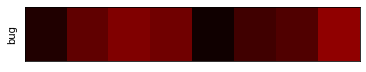

D:\IDG_Malta_Master_Thesis\pokemon_assets_generation\_Sprite_Sheets\PokeTypeGAN-main\sprites\all_transparent\generated_types\dark


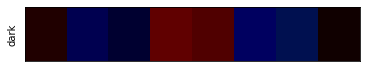

D:\IDG_Malta_Master_Thesis\pokemon_assets_generation\_Sprite_Sheets\PokeTypeGAN-main\sprites\all_transparent\generated_types\dragon


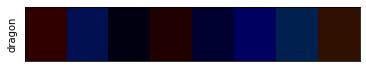

D:\IDG_Malta_Master_Thesis\pokemon_assets_generation\_Sprite_Sheets\PokeTypeGAN-main\sprites\all_transparent\generated_types\electric


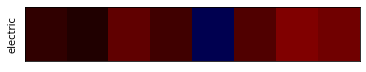

D:\IDG_Malta_Master_Thesis\pokemon_assets_generation\_Sprite_Sheets\PokeTypeGAN-main\sprites\all_transparent\generated_types\fairy


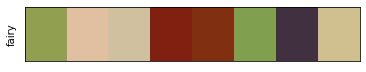

D:\IDG_Malta_Master_Thesis\pokemon_assets_generation\_Sprite_Sheets\PokeTypeGAN-main\sprites\all_transparent\generated_types\fighting


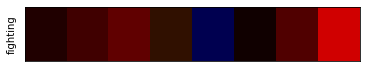

D:\IDG_Malta_Master_Thesis\pokemon_assets_generation\_Sprite_Sheets\PokeTypeGAN-main\sprites\all_transparent\generated_types\fire


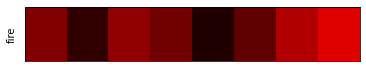

D:\IDG_Malta_Master_Thesis\pokemon_assets_generation\_Sprite_Sheets\PokeTypeGAN-main\sprites\all_transparent\generated_types\flying


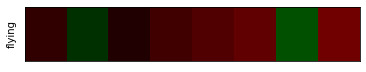

D:\IDG_Malta_Master_Thesis\pokemon_assets_generation\_Sprite_Sheets\PokeTypeGAN-main\sprites\all_transparent\generated_types\ghost


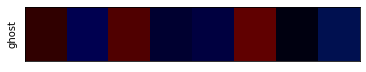

D:\IDG_Malta_Master_Thesis\pokemon_assets_generation\_Sprite_Sheets\PokeTypeGAN-main\sprites\all_transparent\generated_types\grass


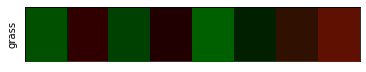

D:\IDG_Malta_Master_Thesis\pokemon_assets_generation\_Sprite_Sheets\PokeTypeGAN-main\sprites\all_transparent\generated_types\ground


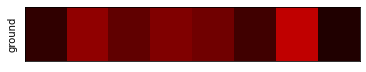

D:\IDG_Malta_Master_Thesis\pokemon_assets_generation\_Sprite_Sheets\PokeTypeGAN-main\sprites\all_transparent\generated_types\ice


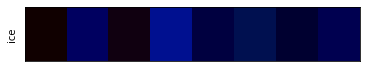

D:\IDG_Malta_Master_Thesis\pokemon_assets_generation\_Sprite_Sheets\PokeTypeGAN-main\sprites\all_transparent\generated_types\normal


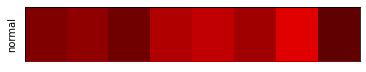

D:\IDG_Malta_Master_Thesis\pokemon_assets_generation\_Sprite_Sheets\PokeTypeGAN-main\sprites\all_transparent\generated_types\poison


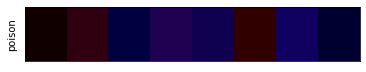

D:\IDG_Malta_Master_Thesis\pokemon_assets_generation\_Sprite_Sheets\PokeTypeGAN-main\sprites\all_transparent\generated_types\psychic


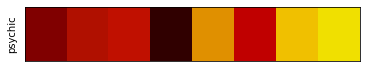

D:\IDG_Malta_Master_Thesis\pokemon_assets_generation\_Sprite_Sheets\PokeTypeGAN-main\sprites\all_transparent\generated_types\rock


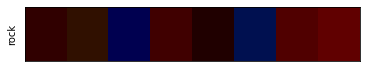

D:\IDG_Malta_Master_Thesis\pokemon_assets_generation\_Sprite_Sheets\PokeTypeGAN-main\sprites\all_transparent\generated_types\steel


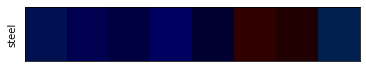

D:\IDG_Malta_Master_Thesis\pokemon_assets_generation\_Sprite_Sheets\PokeTypeGAN-main\sprites\all_transparent\generated_types\water


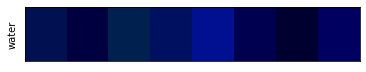

In [11]:
generated_type_folders = glob("D:\IDG_Malta_Master_Thesis\pokemon_assets_generation\_Sprite_Sheets\PokeTypeGAN-main\sprites\\all_transparent\generated_types/*")
get_color_palette_chart_for_all_types(generated_type_folders, 125)

D:\IDG_Malta_Master_Thesis\pokemon_assets_generation\_Sprite_Sheets\PokeTypeGAN-main\sprites\sprite_fronts_only_transparent\bug


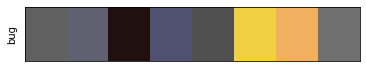

D:\IDG_Malta_Master_Thesis\pokemon_assets_generation\_Sprite_Sheets\PokeTypeGAN-main\sprites\sprite_fronts_only_transparent\dark


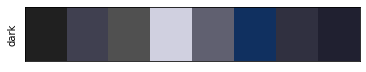

D:\IDG_Malta_Master_Thesis\pokemon_assets_generation\_Sprite_Sheets\PokeTypeGAN-main\sprites\sprite_fronts_only_transparent\dragons


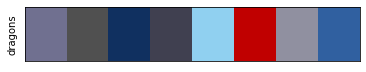

D:\IDG_Malta_Master_Thesis\pokemon_assets_generation\_Sprite_Sheets\PokeTypeGAN-main\sprites\sprite_fronts_only_transparent\electric


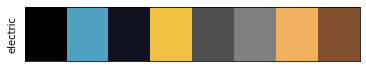

D:\IDG_Malta_Master_Thesis\pokemon_assets_generation\_Sprite_Sheets\PokeTypeGAN-main\sprites\sprite_fronts_only_transparent\fairy


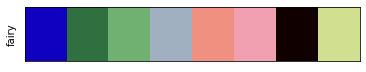

D:\IDG_Malta_Master_Thesis\pokemon_assets_generation\_Sprite_Sheets\PokeTypeGAN-main\sprites\sprite_fronts_only_transparent\fighting


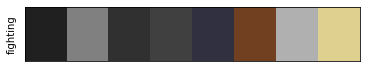

D:\IDG_Malta_Master_Thesis\pokemon_assets_generation\_Sprite_Sheets\PokeTypeGAN-main\sprites\sprite_fronts_only_transparent\fire


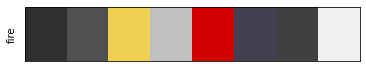

D:\IDG_Malta_Master_Thesis\pokemon_assets_generation\_Sprite_Sheets\PokeTypeGAN-main\sprites\sprite_fronts_only_transparent\flying


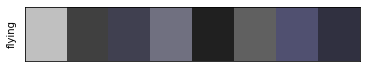

D:\IDG_Malta_Master_Thesis\pokemon_assets_generation\_Sprite_Sheets\PokeTypeGAN-main\sprites\sprite_fronts_only_transparent\ghost


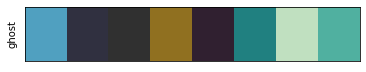

D:\IDG_Malta_Master_Thesis\pokemon_assets_generation\_Sprite_Sheets\PokeTypeGAN-main\sprites\sprite_fronts_only_transparent\grass


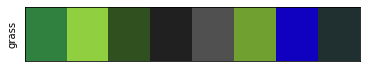

D:\IDG_Malta_Master_Thesis\pokemon_assets_generation\_Sprite_Sheets\PokeTypeGAN-main\sprites\sprite_fronts_only_transparent\ground


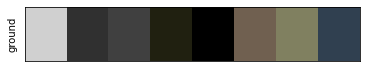

D:\IDG_Malta_Master_Thesis\pokemon_assets_generation\_Sprite_Sheets\PokeTypeGAN-main\sprites\sprite_fronts_only_transparent\ice


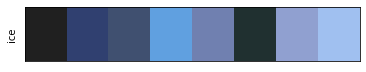

D:\IDG_Malta_Master_Thesis\pokemon_assets_generation\_Sprite_Sheets\PokeTypeGAN-main\sprites\sprite_fronts_only_transparent\normal


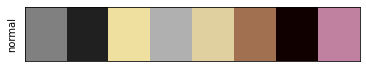

D:\IDG_Malta_Master_Thesis\pokemon_assets_generation\_Sprite_Sheets\PokeTypeGAN-main\sprites\sprite_fronts_only_transparent\poison


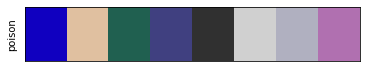

D:\IDG_Malta_Master_Thesis\pokemon_assets_generation\_Sprite_Sheets\PokeTypeGAN-main\sprites\sprite_fronts_only_transparent\psychic


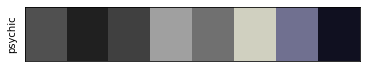

D:\IDG_Malta_Master_Thesis\pokemon_assets_generation\_Sprite_Sheets\PokeTypeGAN-main\sprites\sprite_fronts_only_transparent\rock


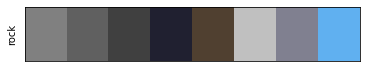

D:\IDG_Malta_Master_Thesis\pokemon_assets_generation\_Sprite_Sheets\PokeTypeGAN-main\sprites\sprite_fronts_only_transparent\steel


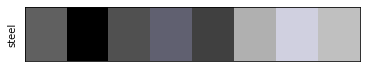

D:\IDG_Malta_Master_Thesis\pokemon_assets_generation\_Sprite_Sheets\PokeTypeGAN-main\sprites\sprite_fronts_only_transparent\water


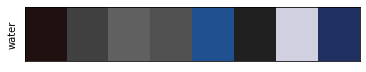

In [10]:
original_type_folders = glob("D:\IDG_Malta_Master_Thesis\pokemon_assets_generation\_Sprite_Sheets\PokeTypeGAN-main\sprites\sprite_fronts_only_transparent/*")
get_color_palette_chart_for_all_types(original_type_folders, 124)

# Blobs

In [164]:
def apply_mask(image_path):
    # Open the image
    image = Image.open(image_path)

    # Convert the image to RGBA mode if it's not already in that mode
    if image.mode != "RGBA":
        image = image.convert("RGBA")

    # Create a new blank image of the same size and mode
    new_image = Image.new("RGBA", image.size, (255, 255, 255, 255))

    # Loop over every pixel in the image
    for x in range(image.width):
        for y in range(image.height):
            # Get the pixel at this position
            pixel = image.getpixel((x, y))

            # If the pixel is transparent, set it to white in the new image
            if pixel[3] == 0:
                new_image.putpixel((x, y), (255, 255, 255, 255))
            # Otherwise, set it to black
            else:
                new_image.putpixel((x, y), (0, 0, 0, 255))

    # Save the new image
    return new_image

In [215]:
# Symmetry
def get_symmetry_score(image_path):
    # Load the image
    img = apply_mask(image_path)

    # Split the image in half
    w, h = img.size
    half = w // 2  # horizontal axis of symmetry
    left = img.crop((0, 0, half, h))
    right = img.crop((half, 0, w, h))

    # Flip one half
    right = right.transpose(Image.FLIP_LEFT_RIGHT)

    # Calculate the absolute difference
    diff = np.abs(np.array(left) - np.array(right))

    # Threshold the difference
    threshold = 20
    mask = diff > threshold

    # Count the number of non-zero pixels in the mask
    symmetry_score = np.count_nonzero(mask)
    return symmetry_score

In [ ]:
generated_shape_folders = glob("all_transparent/generated_shapes/*")
for shape in generated_shape_folders:
    symmetries_score = []
    all_sprites = glob(type + "/*.png")
    for sprite in all_sprites:
        symmetry_score = get_symmetry_score(sprite)
        symmetries_score.append(symmetry_score)
    avg_symmetry = np.average(symmetries_score)
    print(str(shape) + " " + str(avg_symmetry))

In [252]:
generated_shape_folders_armor = glob("all_transparent/original_shapes/wings/*.png")
for sprite in generated_shape_folders_armor:
    symmetry_score = get_symmetry_score(sprite)
    # print(symmetry_score)
    symmetries_score.append(symmetry_score)
avg_symmetry = np.average(symmetries_score)
print(str(shape) + " " + str(avg_symmetry))

all_transparent/generated_shapes\ball 652.9032096288867
